In [31]:
from matplotlib import font_manager, rcParams
import matplotlib as mpl
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}
import matplotlib.pyplot as plt

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [33]:
proj_name = "hs_mode_illustration"
from pathlib import Path

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)


/var/folders/wl/5x49grmn56v77c01bw965mj00000gn/T/ipykernel_4197/965656324.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


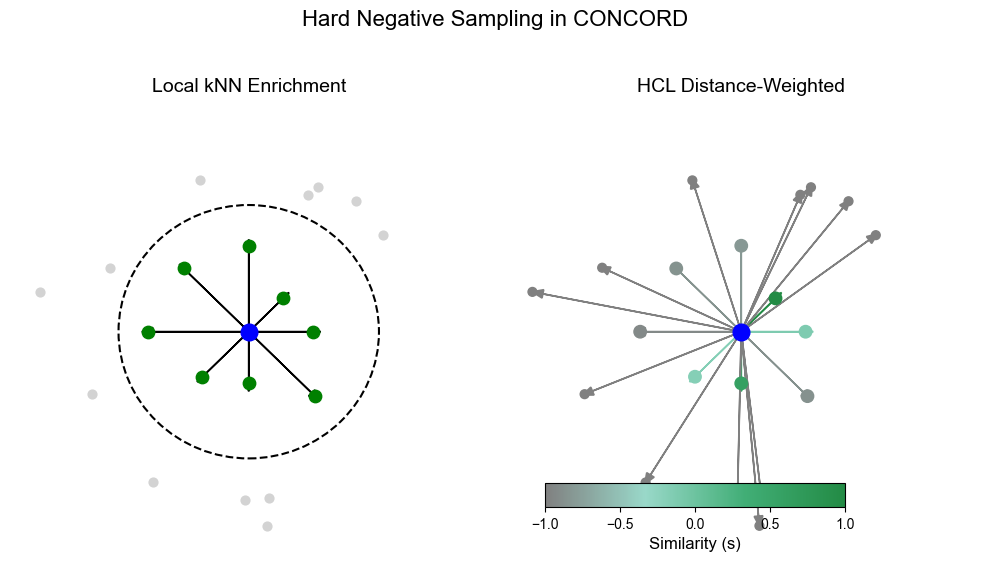

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

# Create figure with two subplots
with plt.style.context(custom_rc):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    fig.suptitle('Hard Negative Sampling in CONCORD', fontsize=16)

    # Parameters
    kappa = 5.0  # Concentration parameter for vMF kernel (beta / T)
    max_r = 2.0  # Approximate max distance for scaling

    # Generate common points for both panels
    num_inner = 8
    theta_inner = np.linspace(0, 2 * np.pi, num_inner, endpoint=False)
    r_inner = np.random.uniform(0.4, 1.0, num_inner)
    x_inner = r_inner * np.cos(theta_inner)
    y_inner = r_inner * np.sin(theta_inner)

    num_outer = 12
    theta_outer = np.random.uniform(0, 2 * np.pi, num_outer)
    r_outer = np.random.uniform(1.4, 2.0, num_outer)
    x_outer = r_outer * np.cos(theta_outer)
    y_outer = r_outer * np.sin(theta_outer)

    # Combine for HCL (all points)
    x_all = np.concatenate((x_inner, x_outer))
    y_all = np.concatenate((y_inner, y_outer))
    dist_all = np.sqrt(x_all**2 + y_all**2)

    # Left subplot: Local kNN enrichment
    ax0 = axs[0]
    ax0.set_title('Local kNN Enrichment', fontsize=14)
    ax0.set_xlim(-2.2, 2.2)
    ax0.set_ylim(-2.2, 2.2)
    ax0.axis('off')

    # Central blue point
    ax0.plot(0, 0, 'o', color='blue', markersize=12, zorder=3)

    # Dashed circle for kNN neighborhood
    radius = 1.2
    circle = Circle((0, 0), radius=radius, fill=False, linestyle='--', color='black', linewidth=1.5)
    ax0.add_patch(circle)

    # Scatter inner (green) and outer (lightgray) points
    ax0.scatter(x_inner, y_inner, color='green', s=80, zorder=2)
    ax0.scatter(x_outer, y_outer, color='lightgray', s=40, zorder=2)

    # Arrows only to inner points
    for i in range(num_inner):
        ax0.arrow(0, 0, x_inner[i] * 0.95, y_inner[i] * 0.95, head_width=0.08, head_length=0.1, fc='black', ec='black', linewidth=1.2, zorder=1)

    # Right subplot: HCL distance-weighted
    ax1 = axs[1]
    ax1.set_title('HCL Distance-Weighted', fontsize=14)
    ax1.set_xlim(-2.2, 2.2)
    ax1.set_ylim(-2.2, 2.2)
    ax1.axis('off')

    # Central blue point
    ax1.plot(0, 0, 'o', color='blue', markersize=12, zorder=3)

    # Use colormap (replace with 'RdBu' or others as needed)
    #cmap = plt.colormaps['plasma'] # 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'RdBu'
    cmap = LinearSegmentedColormap.from_list('prob_cmap', ['gray','#99d8c9', '#41ae76', '#238b45'])
    # Compute similarities and vMF weights
    # Approximate similarity s = cos(pi * dist / max_r) to map dist 0 -> 1, max_r -> -1
    s_all = np.cos(np.pi * dist_all / max_r)
    weights = np.exp(kappa * s_all)
    norm_weights = (weights - weights.min()) / (weights.max() - weights.min())
    colors = cmap(norm_weights)

    # Scatter all points with colors based on vMF weights
    sizes = np.where(dist_all < radius, 80, 40)
    ax1.scatter(x_all, y_all, color=colors, s=sizes, zorder=2)

    # Arrows to all points, colored matching the points
    for i in range(len(x_all)):
        ax1.arrow(0, 0, x_all[i] * 0.95, y_all[i] * 0.95, head_width=0.08, head_length=0.1,
                fc=colors[i], ec=colors[i], linewidth=1.2, zorder=1)

    # Gradient bar for weight (high to low from left to right)
    cax = fig.add_axes([0.55, 0.15, 0.3, 0.04])  # Position for colorbar
    norm = plt.Normalize(-1, 1)  # Corresponding to s from low to high
    cb = ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
    cb.set_label('Similarity (s)', fontsize=12)
    cb.ax.tick_params(labelsize=10)

    # Adjust layout and show
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_dir / 'HCL_vs_kNN_demo.pdf', dpi=300)
    plt.show()